## Business Objective

The objective of this project is to build a machine learning model that can proactively
identify fraudulent financial transactions. The model should not only predict fraud
accurately but also provide interpretable insights that can help the business design
effective fraud prevention strategies.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


## Data Overview

The dataset contains over 6.3 million financial transactions with both numerical and
categorical features. The target variable `isFraud` indicates whether a transaction
is fraudulent. The dataset is highly imbalanced, with fraudulent transactions forming
a very small percentage of the total data.


In [3]:
df = pd.read_csv("fraud.csv")   

df.head()
df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


(6362620, 11)

In [4]:
df['isFraud'].value_counts()
df['isFraud'].value_counts(normalize=True)


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

## Data Cleaning

Data cleaning steps included:
- Removal of identifier columns such as transaction IDs, as they do not provide
  predictive value.
- Encoding categorical variables into numerical format.
- Handling skewed numerical features using log transformation.
- Creating balance difference features to capture abnormal transaction behavior.

These steps help improve model stability and interpretability.


In [5]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True, errors='ignore')



In [6]:
df['amount_log'] = np.log1p(df['amount'])
df.drop('amount', axis=1, inplace=True)


In [7]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)


## Multicollinearity Check

Correlation analysis was performed on numerical features to identify highly correlated
variables and reduce redundancy while preserving important financial signals.


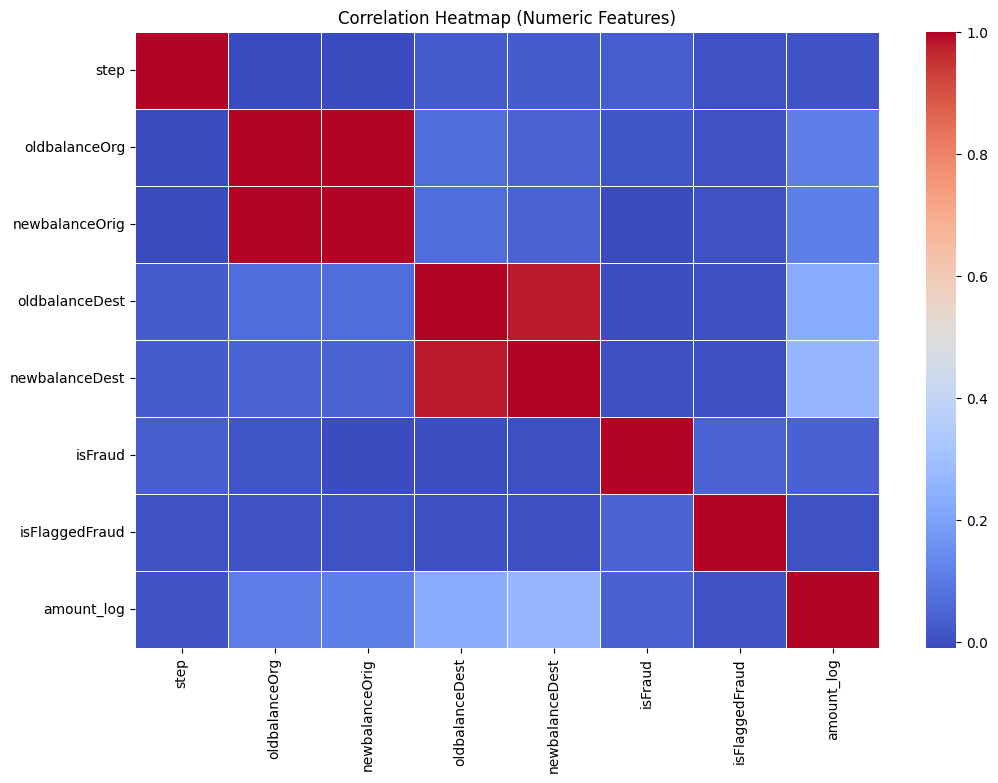

In [8]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [9]:
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['oldbalanceDest'] - df['newbalanceDest']


## Fraud Detection Model

Logistic Regression was used as a baseline model due to its simplicity and interpretability.
Class imbalance was handled using class weighting.


In [10]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [12]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear',
    n_jobs=-1
)

lr.fit(X_train, y_train)


C:\Users\samsm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


## Model Performance Evaluation

Model performance was evaluated using precision, recall, F1-score, and ROC-AUC.
Recall was prioritized due to the imbalanced nature of fraud data.


In [13]:
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1270881
           1       0.03      0.89      0.06      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.93      0.52   1272524
weighted avg       1.00      0.97      0.98   1272524

ROC-AUC: 0.9846119724856252


## Variable Selection

Variables were selected based on domain relevance, correlation analysis, and feature
importance scores obtained from the Random Forest model.


In [14]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.97      0.81      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9968921494964419


## Key Factors Predicting Fraud

Key predictors include transaction type, balance inconsistencies, large transaction
amounts, and abnormal destination balance changes.


In [16]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


balance_diff_orig    0.288557
oldbalanceOrg        0.167715
amount_log           0.124098
newbalanceOrig       0.100132
balance_diff_dest    0.073829
type_TRANSFER        0.070347
type_PAYMENT         0.047482
step                 0.044651
newbalanceDest       0.032630
oldbalanceDest       0.028717
dtype: float64

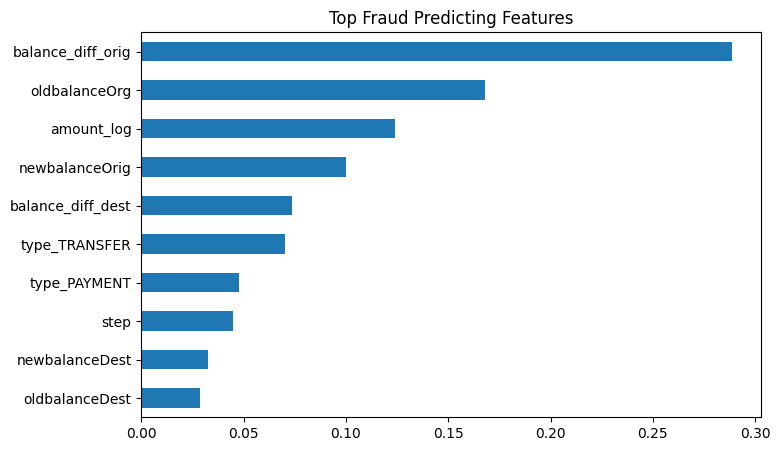

In [17]:
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_features.plot(kind='barh')
plt.title("Top Fraud Predicting Features")
plt.gca().invert_yaxis()
plt.show()


## Interpretation of Fraud Indicators

These factors align with real-world fraud patterns, where fraudulent transactions
often involve rapid fund movement, high-value transfers, and inconsistent balances.


## Fraud Prevention Recommendations

Recommended strategies include real-time fraud scoring, multi-factor authentication
for high-risk transactions, transaction velocity checks, and continuous monitoring systems.


## Measuring Effectiveness of Prevention Strategies

Effectiveness can be measured through reduced fraud rates, improved recall scores,
controlled false positives, and consistent performance during periodic retraining.
